# Generating ROC Curves

In [1]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *
from analysis import *

R, Nch, kb, bw, Nsamp, T= 496.1709043911709, 1, 1.38e-23, 1000e6, 40960, 5

n_pwr = kb * T * bw # noise power
tau_1t = n_pwr * R # noise variance single channel, time-domain (tau_1t)
tau_1f = tau_1t / Nsamp # noise variance single channel, freq-domain (tau_1f)

# Generate example distributions
def calculate_signal_dists(vals, tau, loc, FFT_peaks, Nsamp):

    rice_cdf = np.ones(len(vals))
    for peak in FFT_peaks:
        rice_cdf *= scipy.stats.rice.cdf(vals, b=abs(peak)/np.sqrt(tau/2), loc=loc, scale=np.sqrt(tau/2))
            
    cdf = rice_cdf * (1-np.exp(-(vals**2)/tau)) ** (Nsamp-FFT_peaks.size)

    pdf = np.gradient(cdf, vals[1]-vals[0])
    
    return cdf, pdf
    
def calculate_noise_dists(vals, tau, Nsamp):
    ray_cdf = (1-np.exp(-(vals**2)/tau)) ** Nsamp
    ray_pdf = np.gradient(ray_cdf, vals[1]-vals[0])
    
    return ray_cdf, ray_pdf



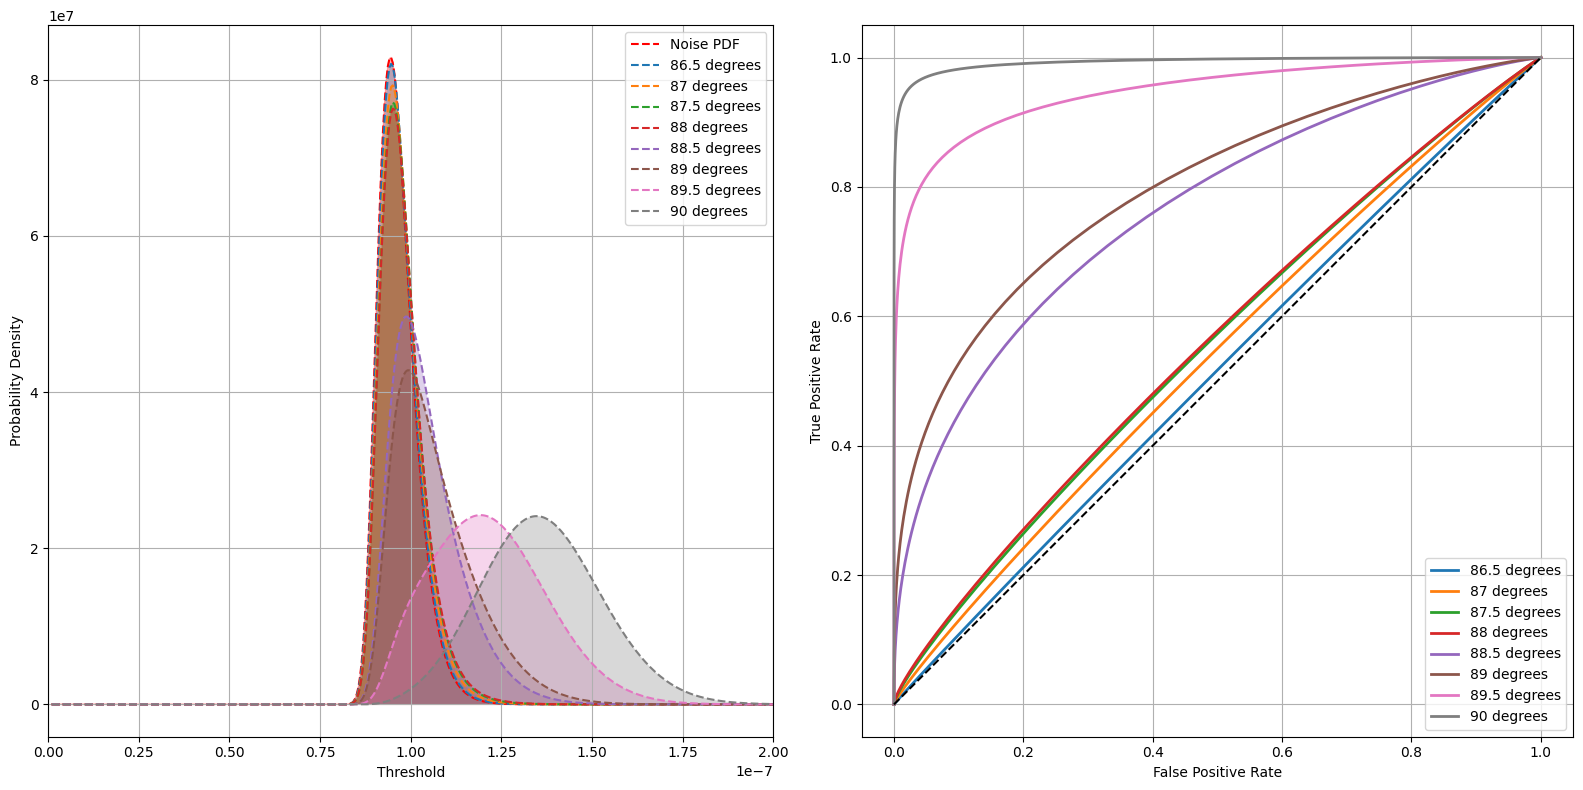

In [2]:
from scipy import stats

threshold = np.linspace(1e-9, 9e-6, 20001)
x = threshold

noise_pdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[1]
# signal_pdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[1]
# signal86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[1]

# Calculate CDFs
noise_cdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[0]
# signal_cdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[0]
# signal_cdf86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[0]

# Calculate ROC points (FPR = 1-specificity, TPR = sensitivity)
fpr = 1 - noise_cdf  # false positive rate


file_list = [
    'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5', 
    'harmonic/87deg/out_0a5c4e19-2fc3-4f5c-9090-8d2cce62ae19.h5', 
    'harmonic/87p5deg/out_0c7fdf39-0ea3-4c84-9a9d-60c68b480bb1.h5', 
    'harmonic/88deg/out_0ad74f8f-ec02-44f5-a5af-5c69bef4774e.h5',
    'harmonic/88p5deg/out_0a1bc7f8-6e25-47f3-9743-f404227c3d0b.h5',
    'harmonic/89deg/out_1a0ad631-1153-47ef-8cba-ea9ab0cefa3d.h5',
    'harmonic/89p5deg/out_51db499d-c8ea-4cce-884b-d9c3e3f44ed1.h5',
    'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5']

harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

# Plot distributions and ROC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot PDFs
ax1.plot(threshold, noise_pdf, 'r--', label='Noise PDF')
ax1.fill_between(threshold, noise_pdf, alpha=0.3, color='red')

aucs = []

for i, file_name in enumerate(file_list):

    # signal_strings, attributes, attrs_container = get_attributes(file_name)
    signal = get_signal(file_name, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    # signal_maximums = signal_FFT[signal_FFT > 1e-8]
    # peaks = np.array(signal_maximums)
    
    # print(peaks)
    
    # signal_max_index = np.argmax(abs(signal_FFT))
    # complex_signal_max = signal_FFT[signal_max_index]

    pks = get_signal_peaks(signal, 1e-8)
    
    # print(peaks)

    rice_cdf = np.ones(20001)
    for peak in pks:
        rice_cdf *= scipy.stats.rice.cdf(x, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)

    signal_pdf = np.gradient(signal_cdf, x[1]-x[0])


    tpr = 1 - signal_cdf  # true positive rate

    signal_label = str(harmonic_angles[i]) + ' degrees'
    
    ax1.plot(threshold, signal_pdf, '--', label=signal_label)
    ax1.fill_between(threshold, signal_pdf, alpha=0.3)
    # Plot ROC curve
    
    roc_label = str(harmonic_angles[i]) + ' degrees'
    
    ax2.plot(fpr, tpr, '-', linewidth=2, label=roc_label) 
    auc = abs(np.trapz(tpr, fpr))
    aucs.append(auc)


ax1.set_xlabel('Threshold')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.set_xlim(0, 0.2e-6)
ax1.grid(True)


ax2.plot([0, 1], [0, 1], 'k--')  # random guess line
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.grid(True)
ax2.set_aspect('equal')
ax2.legend()

plt.tight_layout()
plt.savefig('harmonic_roc.png')
plt.show()

# 3D Plots

 Here we are going to figure out the scheme for generating a ROC curve for a single event, store it's AUC and Efficiency and plot these 3D planes.

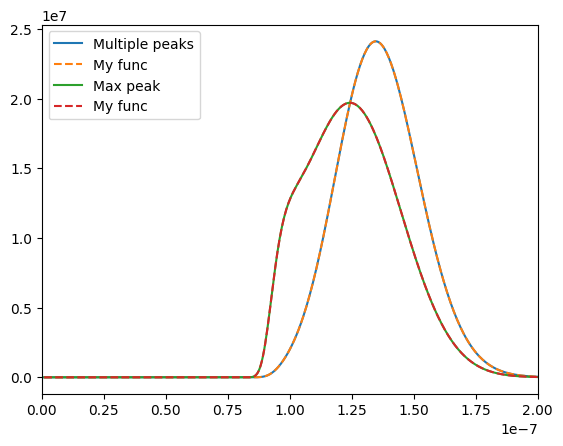

In [3]:
pks = get_signal_peaks(signal, 5e-8)

signal_pdf, signal_cdf = calculate_signal_dists(threshold, tau_1f, 0, pks, Nsamp)


rice_cdf = np.ones(20001)
for peak in pks:
    rice_cdf *= scipy.stats.rice.cdf(x, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
    
signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)

signal_pdf = np.gradient(signal_cdf, x[1]-x[0])

plt.plot(x, signal_pdf, label='Multiple peaks')

cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)

plt.plot(x, pdf, label='My func', linestyle='--')


rice_cdf = np.ones(20001)
rice_cdf *= scipy.stats.rice.cdf(x, b=abs(np.max(pks))/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)
signal_pdf = np.gradient(signal_cdf, x[1]-x[0])

plt.plot(x, signal_pdf, label='Max peak')

cdf, pdf = get_dists(np.array([abs(np.max(pks))]), x, tau_1f, Nsamp)

plt.plot(x, pdf, label='My func', linestyle='--')

plt.xlim(0, 0.2e-6)
plt.legend()

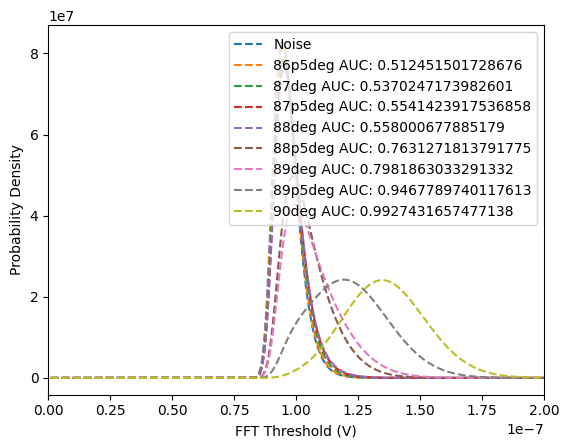

In [4]:
noise_cdf, noise_pdf = get_dists([], x, tau_1f, Nsamp)

def get_roc(noise_cdf, signal_cdf):
    fpr = 1 - noise_cdf
    tpr = 1 - signal_cdf
    
    return fpr, tpr

    
plt.plot(x, noise_pdf, label='Noise', linestyle='--')


for filename in file_list:
    
    signal = get_signal(filename, 'signal1') # One polarisation

    pks = get_signal_peaks(signal, 1e-9)
    cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)
    
    fpr,tpr = get_roc(noise_cdf, cdf)
    auc = abs(np.trapz(tpr, fpr))
    
    
    label = filename.split('/')[1].split('.')[0] + ' AUC: ' + str(auc)
    
    # plt.text(0.1e-6, 0.1e6, str(label) + ' AUC: ' + str(auc))

    
    plt.plot(x, pdf, label=label, linestyle='--')

    plt.xlim(0, 0.2e-6)

plt.xlabel('FFT Threshold (V)')
plt.ylabel('Probability Density')

plt.legend()

plt.savefig('harmonic_dists.png')

plt.show(  )


In [19]:
path_to_all = '../../../../Desktop/v2/Harmonic/*/*.h5'

file_list = glob.glob(path_to_all)

angles = []

for file_ in file_list:
    
    angle = file_.split('/')[-2]
    angles.append(angle)
    
zip_list = sorted(zip(file_list, angles))

file_list, angles = zip(*zip_list)

inds = np.where(np.array(angles) == '90.0deg')

files_90 = file_list[inds]

print(files_90)

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:

degrees = []
aucs = []
efficiencies10 = []
efficiencies5 = []
efficiencies1 = []

for i, filename in enumerate(glob.glob(path_to_all)):
    
    
    signal = get_signal(filename, 'signal1') # One polarisation

    pks = get_signal_peaks(signal, 1e-9)
    cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)
    
    fpr,tpr = get_roc(noise_cdf, cdf)
    auc = abs(np.trapz(tpr, fpr))
    
    ind = np.where(fpr < 0.1)[0][0]
    eff = tpr[ind]
    efficiencies10.append(eff)
    
    ind = np.where(fpr < 0.05)[0][0]
    eff = tpr[ind]
    efficiencies5.append(eff)
    
    ind = np.where(fpr < 0.01)[0][0]
    eff = tpr[ind]
    efficiencies1.append(eff)
    
    degrees.append(filename.split('/')[-2])
    aucs.append(auc)
    



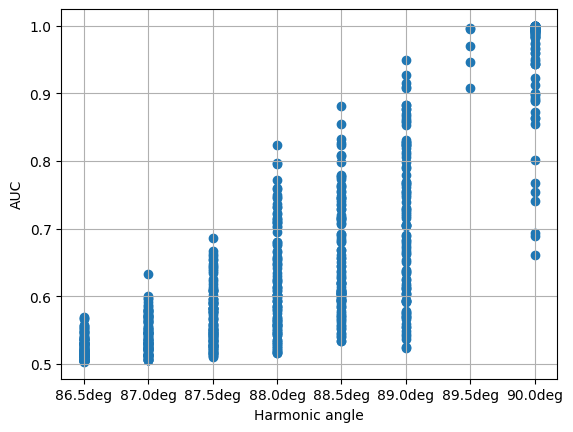

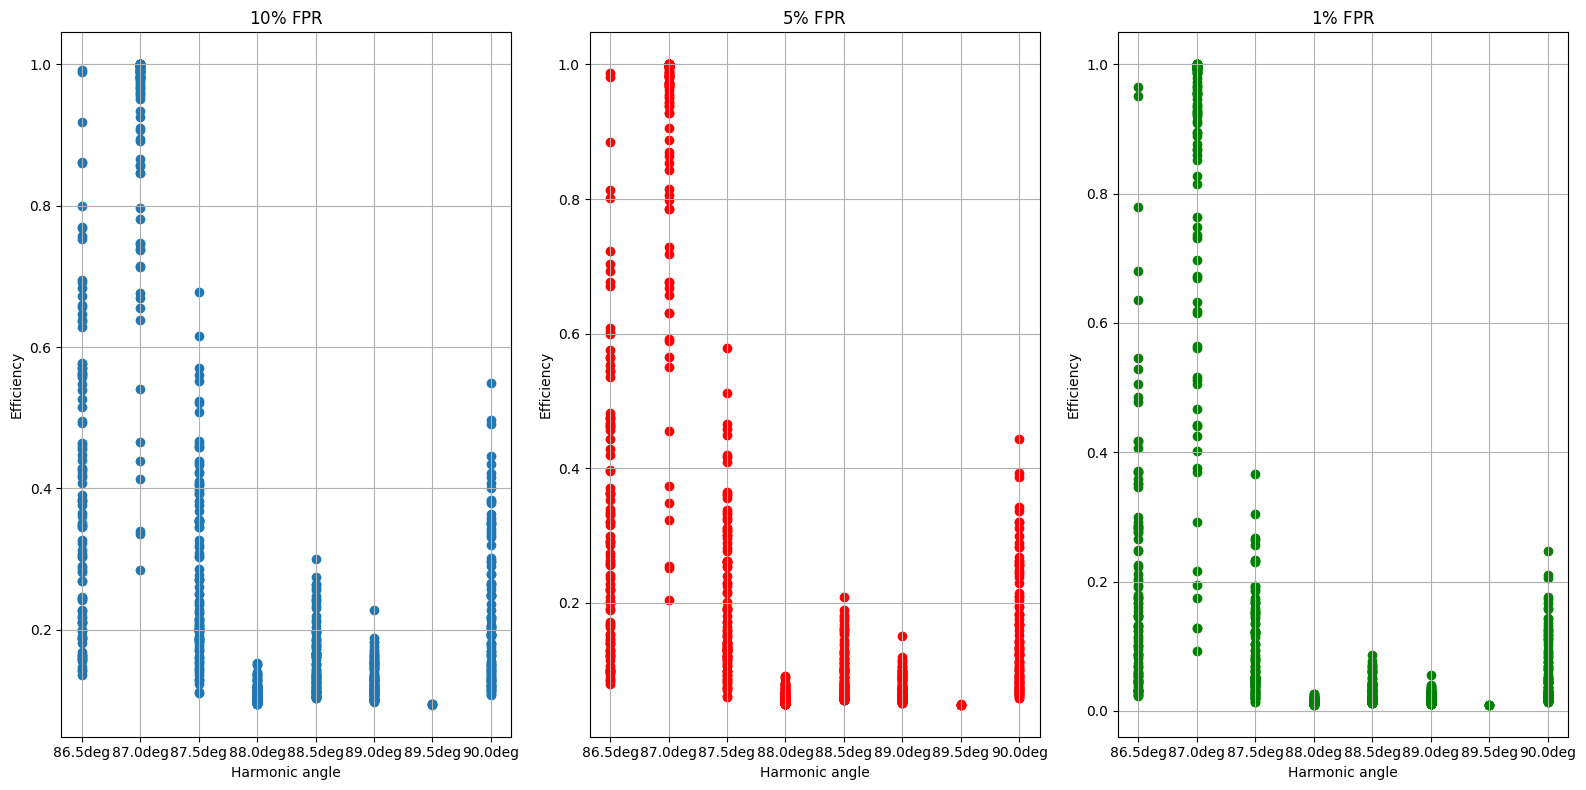

In [8]:
sorted_data = sorted(zip(degrees, aucs, efficiencies10, efficiencies5, efficiencies1))
sorted_degrees, sorted_aucs, efficiencies10, efficiencies5, efficiencies1 = zip(*sorted_data)

# sorted_degrees, sorted_aucs, efficiencies10 = zip(*sorted_data)

# sorted_degrees, sorted_aucs, efficiencies10 = zip(*sorted_data)

plt.scatter(sorted_degrees, sorted_aucs)
plt.xlabel('Harmonic angle')
plt.ylabel('AUC')
plt.grid(True)

plt.savefig('../figures/harmonic_auc.png')

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

axs[0].scatter(sorted_degrees, efficiencies10)
axs[0].set_xlabel('Harmonic angle')
axs[0].set_ylabel('Efficiency')
axs[0].set_title('10$\%$ FPR')
axs[0].grid(True)

axs[1].scatter(sorted_degrees, efficiencies5, color='red')
axs[1].set_xlabel('Harmonic angle')
axs[1].set_ylabel('Efficiency')
axs[1].set_title('5$\%$ FPR')
axs[1].grid(True)

axs[2].scatter(sorted_degrees, efficiencies1, color='green')
axs[2].set_xlabel('Harmonic angle')
axs[2].set_ylabel('Efficiency')
axs[2].set_title('1$\%$ FPR')
axs[2].grid(True)

plt.tight_layout()

plt.savefig('../figures/harmonic_efficiencies.png')

plt.show()

# plt.scatter(sorted_degrees, efficiencies10, label='10$\%$ FPR')
# plt.scatter(sorted_degrees, efficiencies5, label='5$\%$ FPR')
# plt.scatter(sorted_degrees, efficiencies1, label='1$\%$ FPR')
# plt.xlabel('Harmonic angle')
# plt.ylabel('Efficiency')
# plt.legend()
# plt.grid(True)
# plt.show()







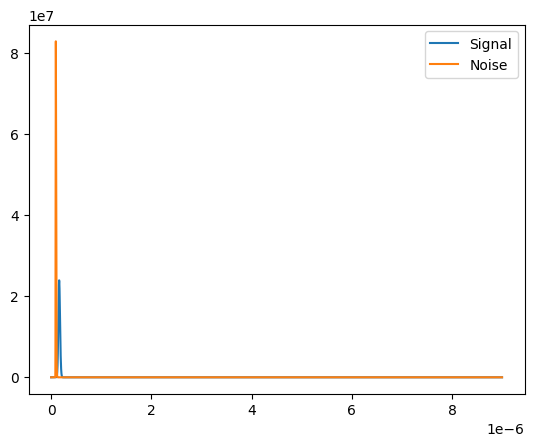

0.9999022610527654
0.9997951943432187
0.999055952173791


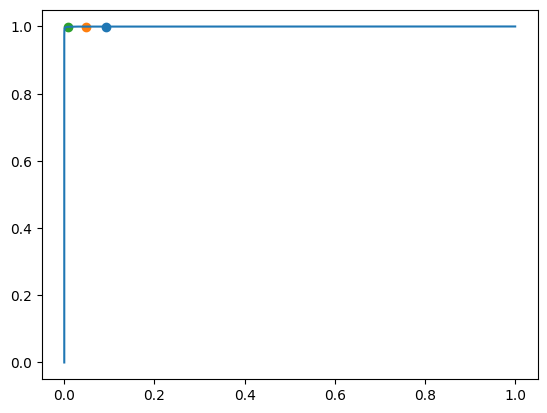

In [ ]:
listoffiles = glob.glob(path_to_all)
test = listoffiles[348]

signal = get_signal(test, 'signal1') # One polarisation

pks = get_signal_peaks(signal, 1e-9)
cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)

fpr,tpr = get_roc(noise_cdf, cdf)

plt.plot(x, pdf, label='Signal')
plt.plot(x, noise_pdf, label='Noise')
plt.legend()
plt.show()



plt.plot(fpr, tpr, label='ROC curve')

ind = np.where(fpr < 0.1)[0][0]

print(tpr[ind])


plt.scatter(fpr[ind], tpr[ind], label='10$\%$ FPR')

ind = np.where(fpr < 0.05)[0][0]
print(tpr[ind])

plt.scatter(fpr[ind], tpr[ind], label='5$\%$ FPR')

ind = np.where(fpr < 0.01)[0][0]
print(tpr[ind])

plt.scatter(fpr[ind], tpr[ind], label='1$\%$ FPR')

plt.show()




In [ ]:
ind = np.where(fpr < 0.1)[0][0]

tpr[ind]



0.9808755912355127

In [ ]:
print(fpr)

[1. 1. 1. ... 0. 0. 0.]


In [ ]:
savefile = '../data/simulations_truth/harmonic.csv'

import pandas as pd

pd.read_csv(savefile)